In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import datetime as dt
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D

devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[0], 'GPU')

def build_generator():
    noise_shape = (z_dim, )
    activation = Activation("relu")

    model = Sequential(name='Generator')

    model.add(Dense(1024, input_shape=noise_shape))
    model.add(activation)
    model.add(BatchNormalization())

    model.add(Dense(7 * 7 * 128))
    model.add(activation)
    model.add(BatchNormalization())

    # 畳み込み層に7 * 7の画像を与える
    model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))

    # UpSamplingをし、画像を14 * 14にする
    # 間の要素は０で埋める
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, 5, padding="same"))
    model.add(activation)

    # UpSamplingをし、画像を28 * 28にする
    model.add(UpSampling2D((2, 2)))

    # 畳み込む（ゼロパディングをして、5*5のレイヤーで畳み込み）
    model.add(Conv2D(1, 5, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    return model

def build_discriminator():
    activation = LeakyReLU(alpha=0.2)

    model = Sequential(name='Discriminator')

    # 畳み込む（ゼロパディングをし、5*5のフィルタを2マスごとに動かす）
    model.add(Conv2D(64, 5, strides=(2, 2), padding="same", input_shape=(img_shape)))
    model.add(activation)

    # 畳み込み2回目
    model.add(Conv2D(128, 5, strides=(2, 2)))
    model.add(activation)

    # 入力の平坦化（多分１次元化ってこと）
    model.add(Flatten())

    model.add(Dense(256))
    model.add(activation)
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.summary()

    return model


def build_combined():
    discriminator.trainable = False
    model = Sequential([generator, discriminator], name='Combined')
    model.summary()

    return model

def save_imgs(log_path, epoch):
    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{}/{}.png".format(log_path, epoch))
    plt.show()
    plt.close()

def train(epochs, batch_size=512, save_interval=1):
    # データセットをダウンロードして読み込む
    (X_train, _),(_, _) = mnist.load_data()
    
    # -1 ～ 1の範囲にする
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis = 3)

    half_batch = int(batch_size / 2)
    num_batches = int(X_train.shape[0] / half_batch)
    print("Number of Batches : ", num_batches)

    log_path = 'log/{}/images'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))
    os.makedirs(log_path, exist_ok=True)
    
    for epoch in range(epochs):
        for iteration in range(num_batches):
            # NoiseからGeneratorで生成
            noise = np.random.normal(0, 1, (half_batch, z_dim))
            gen_imgs = generator.predict(noise)

            # データセットから画像をピックアップ
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # それぞれのデータでDiscriminatorを学習
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

            # DiscriminatorのLossを算出
            d_loss = np.add(d_loss_real, d_loss_fake) / 2

            # ノイズ生成
            noise = np.random.normal(0, 1, (batch_size, z_dim))

            # 騙すことが正解になる目的変数
            valid_y = np.array([1] * batch_size)

            #Generatorを学習
            g_loss = combined_model.train_on_batch(noise, valid_y)

        if epoch % save_interval == 0:
            # 生成画像の表示と保存
            print ("epoch:%d, iter:%d,  [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, iteration, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(log_path, epoch)

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819456    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)               

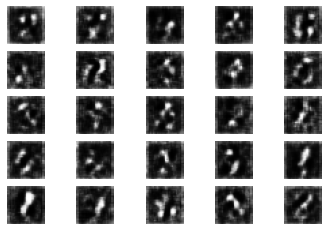

epoch:1, iter:233,  [D loss: 0.691398, acc.: 48.63%] [G loss: 0.689048]


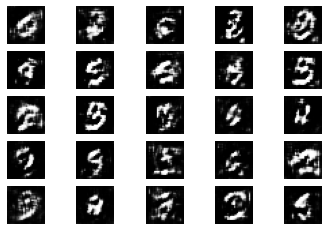

epoch:2, iter:233,  [D loss: 0.695716, acc.: 46.29%] [G loss: 0.700402]


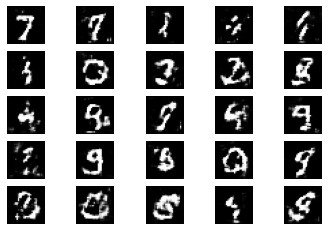

epoch:3, iter:233,  [D loss: 0.696193, acc.: 44.92%] [G loss: 0.702963]


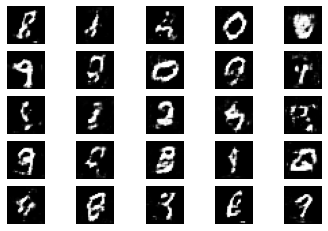

epoch:4, iter:233,  [D loss: 0.692741, acc.: 50.39%] [G loss: 0.703118]


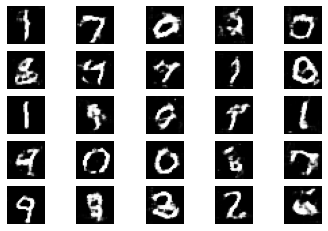

epoch:5, iter:233,  [D loss: 0.695929, acc.: 47.46%] [G loss: 0.705708]


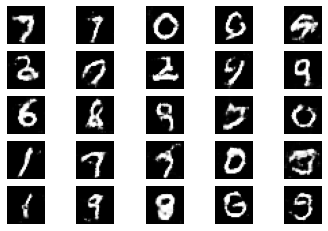

epoch:6, iter:233,  [D loss: 0.693527, acc.: 50.78%] [G loss: 0.716322]


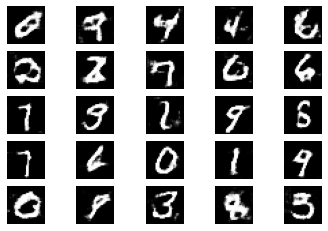

epoch:7, iter:233,  [D loss: 0.698567, acc.: 41.60%] [G loss: 0.699964]


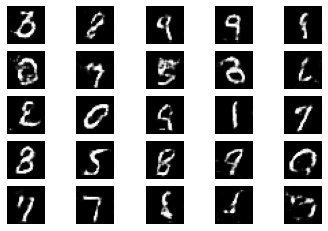

epoch:8, iter:233,  [D loss: 0.694409, acc.: 48.83%] [G loss: 0.692629]


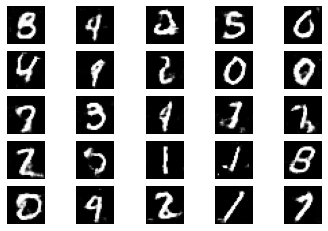

epoch:9, iter:233,  [D loss: 0.696174, acc.: 46.68%] [G loss: 0.705435]


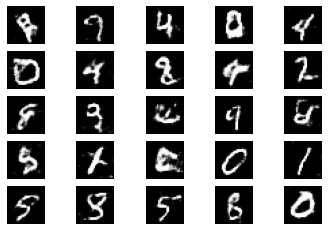

epoch:10, iter:233,  [D loss: 0.690699, acc.: 53.91%] [G loss: 0.709171]


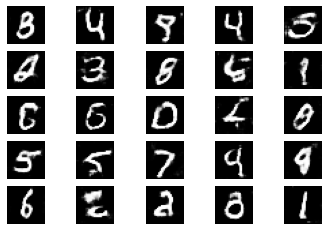

epoch:11, iter:233,  [D loss: 0.687430, acc.: 58.59%] [G loss: 0.714692]


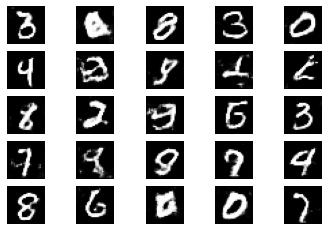

epoch:12, iter:233,  [D loss: 0.689988, acc.: 55.47%] [G loss: 0.706037]


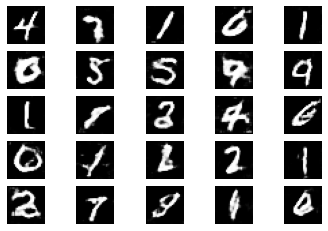

epoch:13, iter:233,  [D loss: 0.695375, acc.: 47.66%] [G loss: 0.699494]


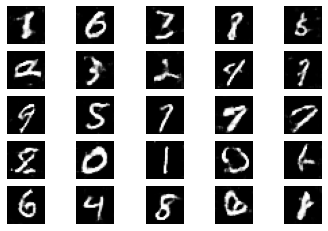

epoch:14, iter:233,  [D loss: 0.694815, acc.: 47.66%] [G loss: 0.705849]


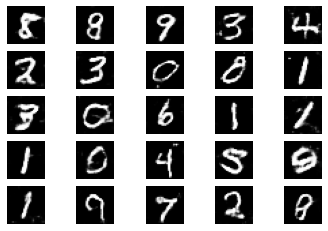

epoch:15, iter:233,  [D loss: 0.699682, acc.: 43.75%] [G loss: 0.698281]


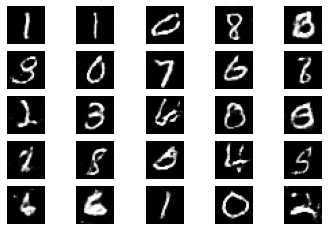

epoch:16, iter:233,  [D loss: 0.694061, acc.: 51.56%] [G loss: 0.701396]


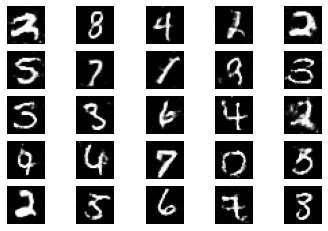

epoch:17, iter:233,  [D loss: 0.691616, acc.: 52.34%] [G loss: 0.700670]


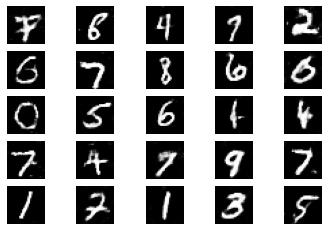

epoch:18, iter:233,  [D loss: 0.693493, acc.: 49.80%] [G loss: 0.698426]


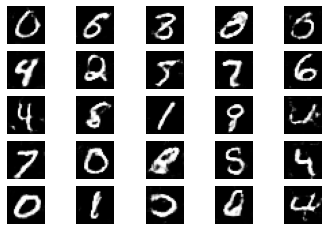

epoch:19, iter:233,  [D loss: 0.690173, acc.: 55.08%] [G loss: 0.708886]


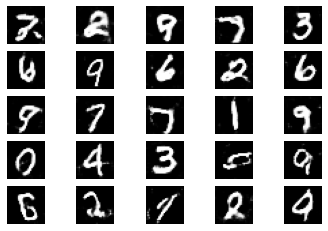

epoch:20, iter:233,  [D loss: 0.693715, acc.: 50.98%] [G loss: 0.702026]


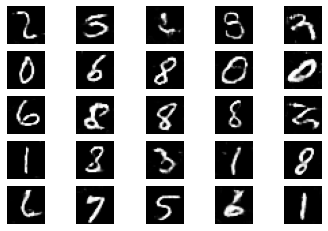

epoch:21, iter:233,  [D loss: 0.691795, acc.: 53.71%] [G loss: 0.703870]


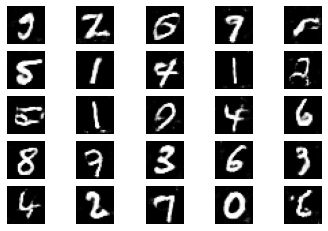

epoch:22, iter:233,  [D loss: 0.694501, acc.: 44.92%] [G loss: 0.699754]


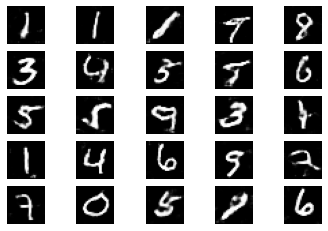

epoch:23, iter:233,  [D loss: 0.691265, acc.: 56.45%] [G loss: 0.695360]


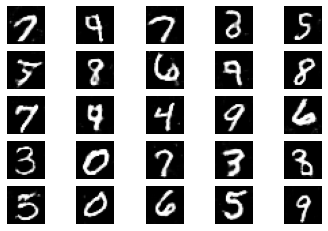

epoch:24, iter:233,  [D loss: 0.691718, acc.: 53.91%] [G loss: 0.705987]


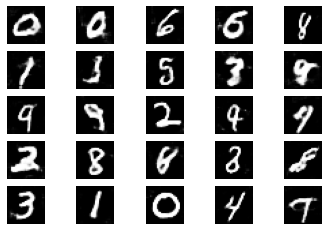

epoch:25, iter:233,  [D loss: 0.692504, acc.: 50.78%] [G loss: 0.695833]


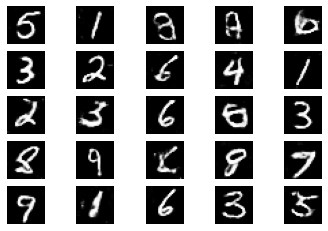

epoch:26, iter:233,  [D loss: 0.689609, acc.: 56.64%] [G loss: 0.710947]


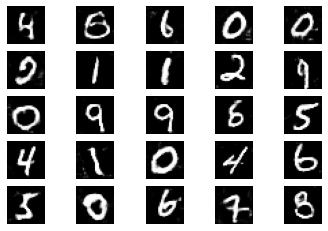

epoch:27, iter:233,  [D loss: 0.695522, acc.: 47.27%] [G loss: 0.698974]


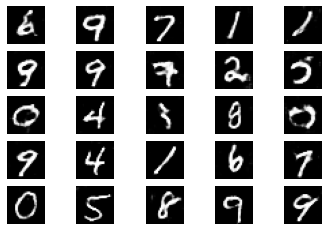

epoch:28, iter:233,  [D loss: 0.694114, acc.: 47.46%] [G loss: 0.700821]


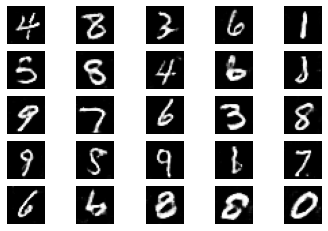

epoch:29, iter:233,  [D loss: 0.692141, acc.: 49.41%] [G loss: 0.698587]


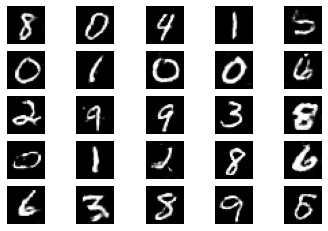

epoch:30, iter:233,  [D loss: 0.693633, acc.: 49.41%] [G loss: 0.699093]


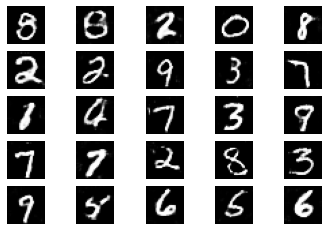

epoch:31, iter:233,  [D loss: 0.698797, acc.: 41.99%] [G loss: 0.698646]


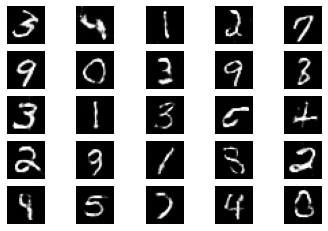

epoch:32, iter:233,  [D loss: 0.692308, acc.: 51.37%] [G loss: 0.702050]


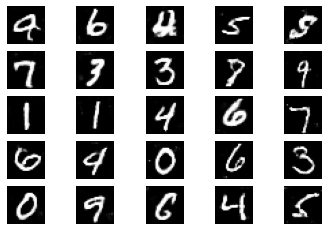

epoch:33, iter:233,  [D loss: 0.693376, acc.: 48.63%] [G loss: 0.702787]


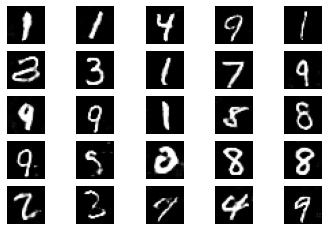

epoch:34, iter:233,  [D loss: 0.692743, acc.: 53.52%] [G loss: 0.699725]


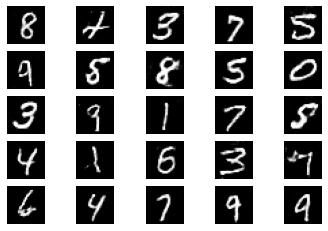

epoch:35, iter:233,  [D loss: 0.692453, acc.: 51.56%] [G loss: 0.700629]


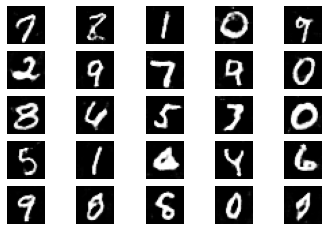

epoch:36, iter:233,  [D loss: 0.694318, acc.: 47.66%] [G loss: 0.699635]


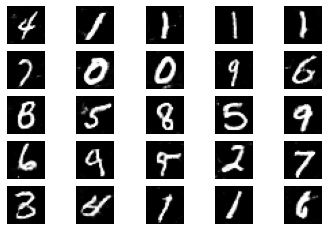

epoch:37, iter:233,  [D loss: 0.692590, acc.: 51.56%] [G loss: 0.702283]


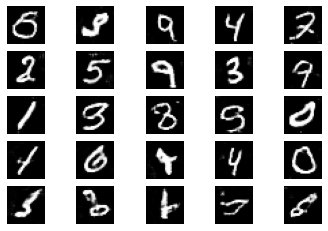

epoch:38, iter:233,  [D loss: 0.691639, acc.: 50.98%] [G loss: 0.700095]


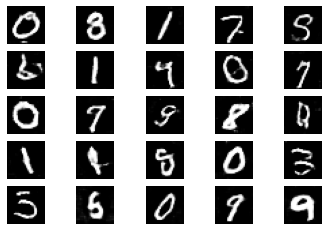

epoch:39, iter:233,  [D loss: 0.693199, acc.: 48.83%] [G loss: 0.699740]


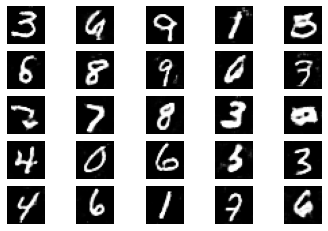

epoch:40, iter:233,  [D loss: 0.693693, acc.: 48.83%] [G loss: 0.702095]


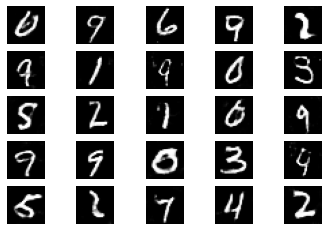

epoch:41, iter:233,  [D loss: 0.693287, acc.: 50.98%] [G loss: 0.702337]


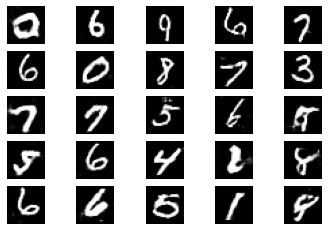

epoch:42, iter:233,  [D loss: 0.692821, acc.: 48.83%] [G loss: 0.701249]


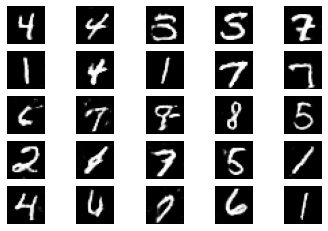

epoch:43, iter:233,  [D loss: 0.691669, acc.: 52.54%] [G loss: 0.698772]


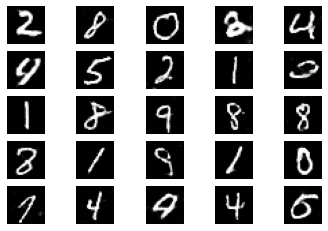

epoch:44, iter:233,  [D loss: 0.691735, acc.: 55.08%] [G loss: 0.698972]


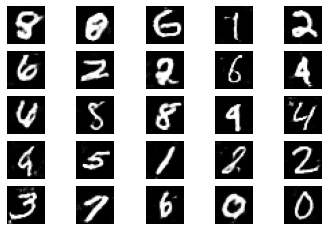

epoch:45, iter:233,  [D loss: 0.690039, acc.: 54.30%] [G loss: 0.705782]


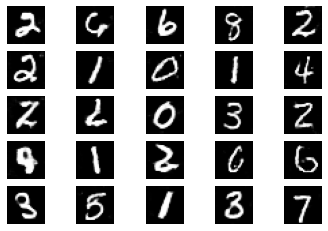

epoch:46, iter:233,  [D loss: 0.690842, acc.: 53.91%] [G loss: 0.698878]


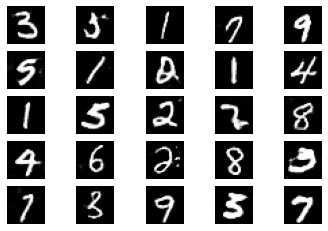

epoch:47, iter:233,  [D loss: 0.691601, acc.: 53.52%] [G loss: 0.700891]


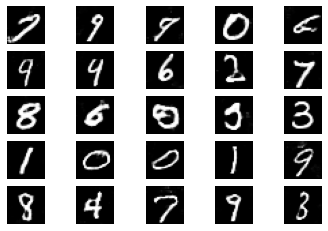

epoch:48, iter:233,  [D loss: 0.688883, acc.: 57.42%] [G loss: 0.704548]


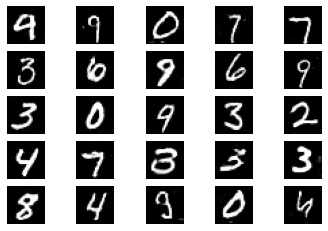

epoch:49, iter:233,  [D loss: 0.690996, acc.: 54.49%] [G loss: 0.702421]


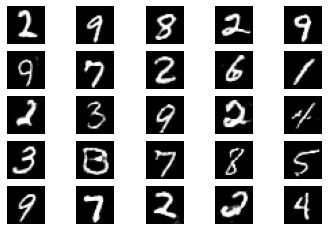

epoch:50, iter:233,  [D loss: 0.690008, acc.: 55.08%] [G loss: 0.704346]


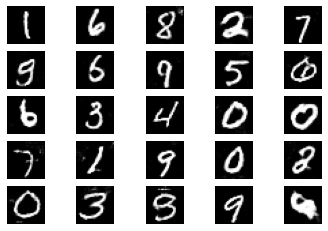

epoch:51, iter:233,  [D loss: 0.693916, acc.: 48.05%] [G loss: 0.707807]


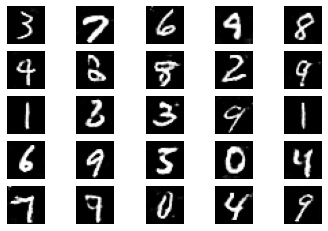

epoch:52, iter:233,  [D loss: 0.692425, acc.: 51.37%] [G loss: 0.701406]


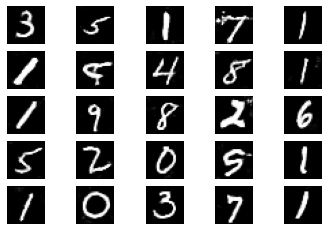

epoch:53, iter:233,  [D loss: 0.691105, acc.: 52.73%] [G loss: 0.704237]


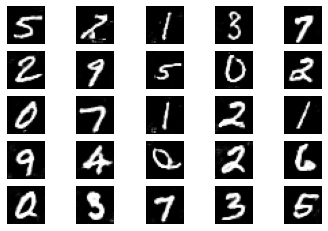

epoch:54, iter:233,  [D loss: 0.691465, acc.: 54.30%] [G loss: 0.701289]


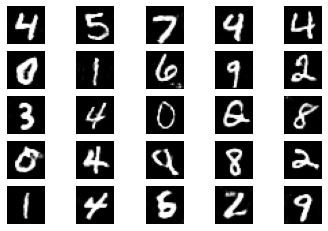

epoch:55, iter:233,  [D loss: 0.691287, acc.: 50.20%] [G loss: 0.701354]


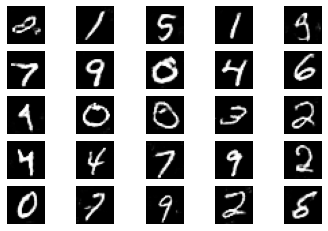

epoch:56, iter:233,  [D loss: 0.692224, acc.: 50.59%] [G loss: 0.704138]


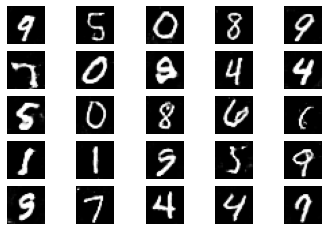

epoch:57, iter:233,  [D loss: 0.688763, acc.: 54.30%] [G loss: 0.706223]


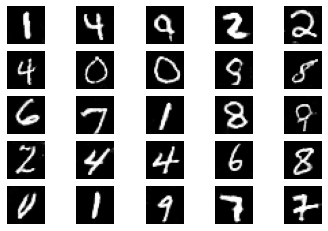

epoch:58, iter:233,  [D loss: 0.690922, acc.: 49.22%] [G loss: 0.704659]


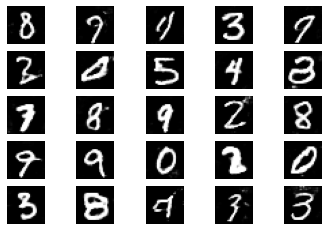

epoch:59, iter:233,  [D loss: 0.692085, acc.: 50.59%] [G loss: 0.705160]


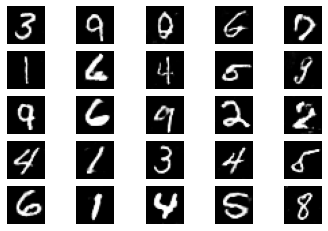

epoch:60, iter:233,  [D loss: 0.691388, acc.: 55.86%] [G loss: 0.706435]


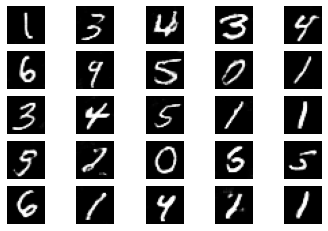

epoch:61, iter:233,  [D loss: 0.694102, acc.: 51.17%] [G loss: 0.706091]


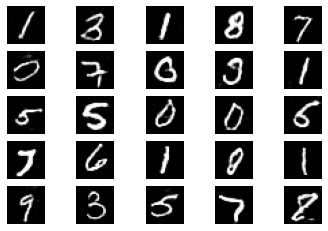

epoch:62, iter:233,  [D loss: 0.690910, acc.: 54.30%] [G loss: 0.705933]


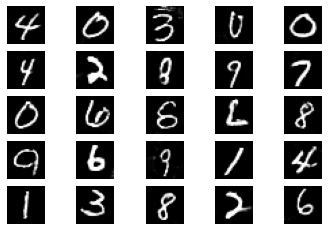

epoch:63, iter:233,  [D loss: 0.688959, acc.: 53.91%] [G loss: 0.710547]


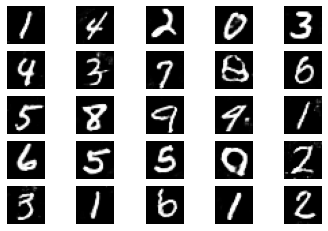

epoch:64, iter:233,  [D loss: 0.691544, acc.: 49.80%] [G loss: 0.705381]


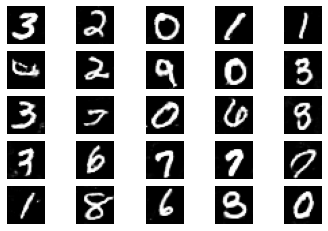

epoch:65, iter:233,  [D loss: 0.690317, acc.: 54.10%] [G loss: 0.706191]


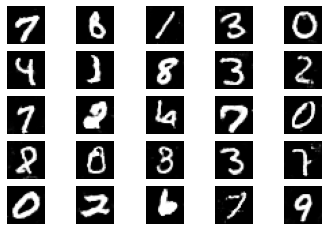

epoch:66, iter:233,  [D loss: 0.693722, acc.: 50.39%] [G loss: 0.704657]


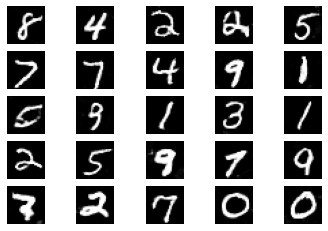

epoch:67, iter:233,  [D loss: 0.687575, acc.: 55.86%] [G loss: 0.704960]


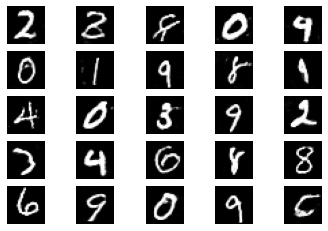

epoch:68, iter:233,  [D loss: 0.689146, acc.: 53.71%] [G loss: 0.711021]


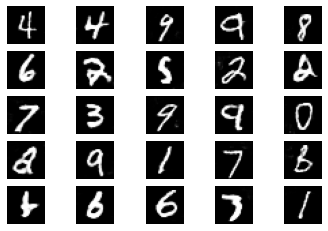

epoch:69, iter:233,  [D loss: 0.691571, acc.: 52.93%] [G loss: 0.707610]


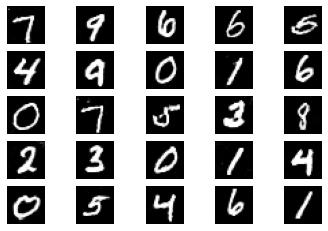

epoch:70, iter:233,  [D loss: 0.688923, acc.: 52.93%] [G loss: 0.710530]


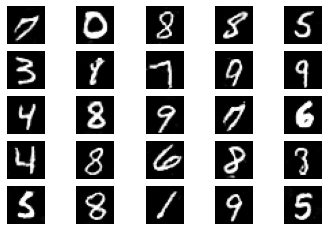

epoch:71, iter:233,  [D loss: 0.690321, acc.: 53.32%] [G loss: 0.710269]


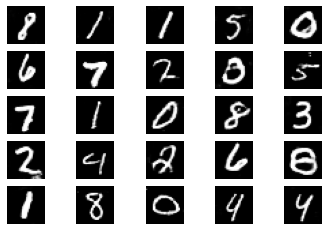

epoch:72, iter:233,  [D loss: 0.690825, acc.: 51.95%] [G loss: 0.715613]


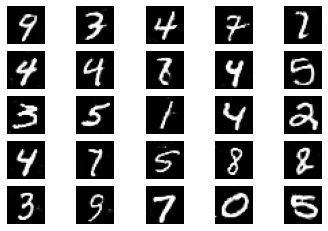

epoch:73, iter:233,  [D loss: 0.688252, acc.: 54.10%] [G loss: 0.708233]


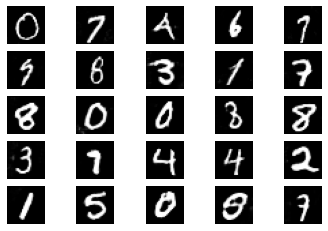

epoch:74, iter:233,  [D loss: 0.691334, acc.: 53.52%] [G loss: 0.710684]


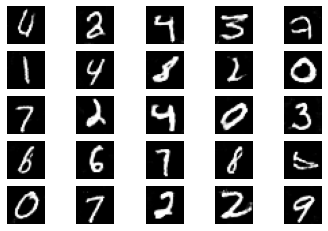

epoch:75, iter:233,  [D loss: 0.688859, acc.: 52.54%] [G loss: 0.710797]


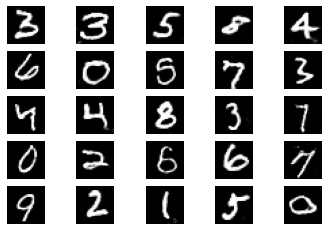

epoch:76, iter:233,  [D loss: 0.688797, acc.: 54.49%] [G loss: 0.712161]


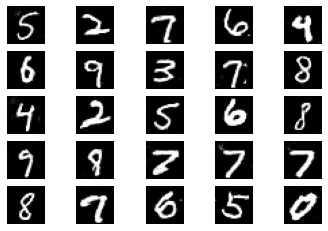

epoch:77, iter:233,  [D loss: 0.689444, acc.: 54.10%] [G loss: 0.716352]


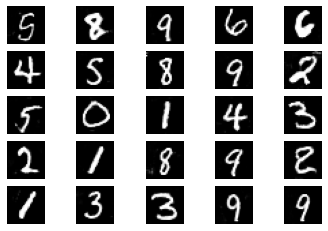

epoch:78, iter:233,  [D loss: 0.685791, acc.: 55.27%] [G loss: 0.713647]


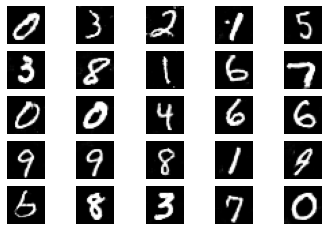

epoch:79, iter:233,  [D loss: 0.688728, acc.: 55.08%] [G loss: 0.710112]


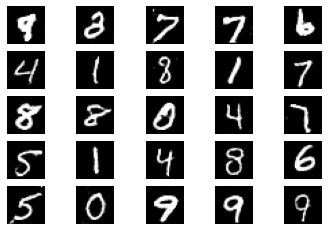

epoch:80, iter:233,  [D loss: 0.692272, acc.: 50.78%] [G loss: 0.713590]


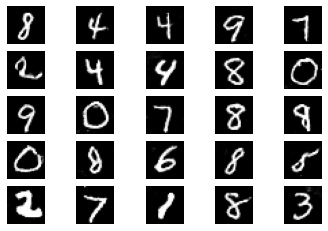

epoch:81, iter:233,  [D loss: 0.684615, acc.: 54.49%] [G loss: 0.717312]


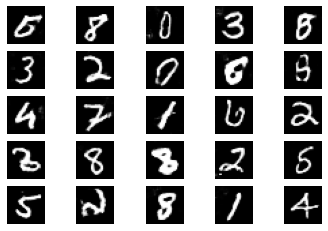

epoch:82, iter:233,  [D loss: 0.685767, acc.: 54.49%] [G loss: 0.712709]


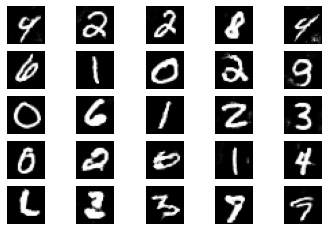

epoch:83, iter:233,  [D loss: 0.687511, acc.: 55.86%] [G loss: 0.715874]


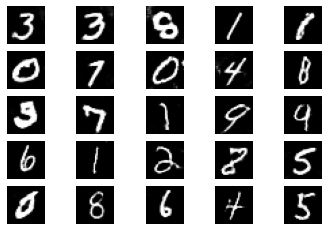

epoch:84, iter:233,  [D loss: 0.686321, acc.: 55.27%] [G loss: 0.727027]


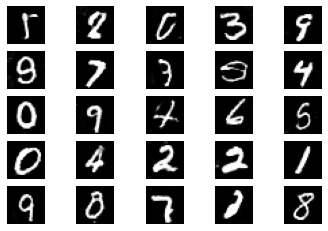

epoch:85, iter:233,  [D loss: 0.689692, acc.: 53.91%] [G loss: 0.720299]


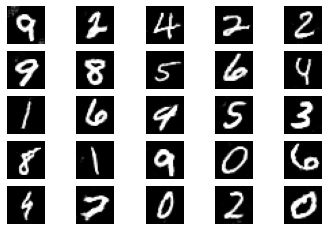

epoch:86, iter:233,  [D loss: 0.688112, acc.: 53.52%] [G loss: 0.714265]


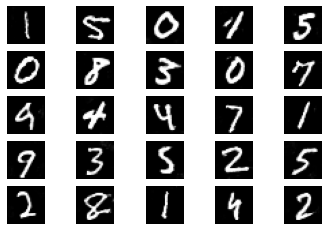

epoch:87, iter:233,  [D loss: 0.682807, acc.: 56.25%] [G loss: 0.721088]


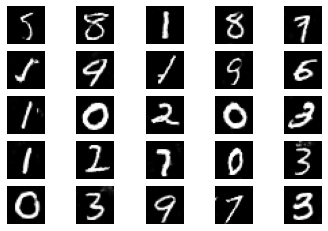

epoch:88, iter:233,  [D loss: 0.688190, acc.: 54.10%] [G loss: 0.712222]


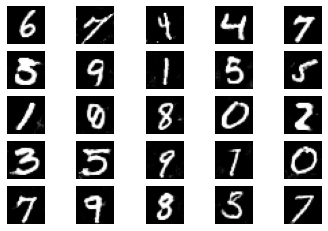

epoch:89, iter:233,  [D loss: 0.688505, acc.: 53.52%] [G loss: 0.721134]


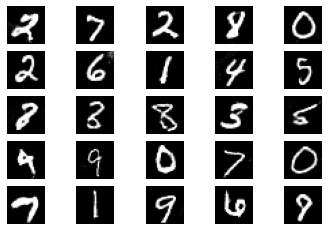

epoch:90, iter:233,  [D loss: 0.688457, acc.: 53.32%] [G loss: 0.716725]


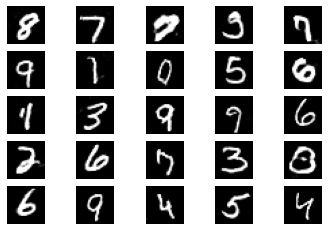

epoch:91, iter:233,  [D loss: 0.685834, acc.: 56.25%] [G loss: 0.723540]


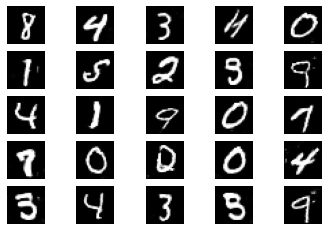

epoch:92, iter:233,  [D loss: 0.684955, acc.: 57.03%] [G loss: 0.724832]


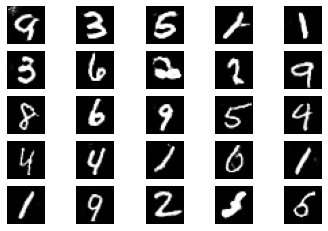

epoch:93, iter:233,  [D loss: 0.685993, acc.: 54.49%] [G loss: 0.723198]


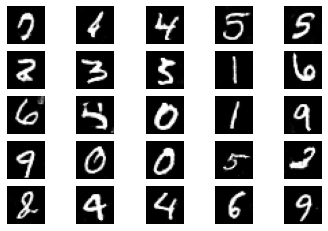

epoch:94, iter:233,  [D loss: 0.685462, acc.: 53.71%] [G loss: 0.719208]


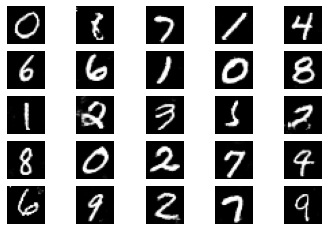

epoch:95, iter:233,  [D loss: 0.685220, acc.: 55.66%] [G loss: 0.725666]


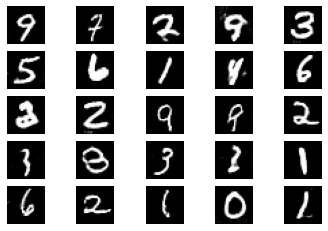

epoch:96, iter:233,  [D loss: 0.689479, acc.: 54.49%] [G loss: 0.729525]


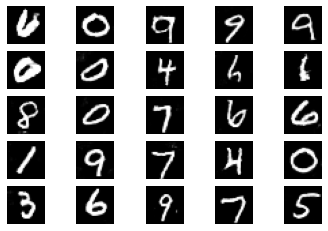

epoch:97, iter:233,  [D loss: 0.684072, acc.: 57.42%] [G loss: 0.720984]


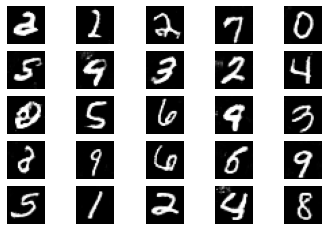

epoch:98, iter:233,  [D loss: 0.685510, acc.: 55.86%] [G loss: 0.733928]


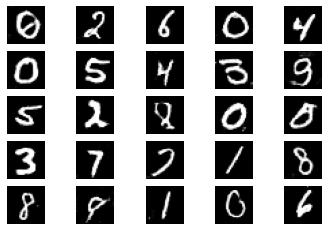

epoch:99, iter:233,  [D loss: 0.689593, acc.: 53.32%] [G loss: 0.723734]


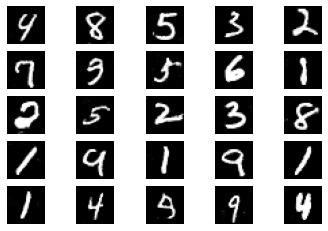

In [2]:
# 入力画像のサイズ
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# ノイズの次元数
z_dim = 20

# 最適化関数
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Generator
generator = build_generator()

# ネットワーク作成
combined_model = build_combined()
combined_model.compile(loss="binary_crossentropy", optimizer=optimizer)

# 学習を実行
train(epochs=100)